In [1]:
import sys
import os
import matplotlib.pyplot as plt
import torch
# Add the src directory to the path. TEMPORARY FIX
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../../..")))

from models.bilstm.bilstm import BiLSTM
from src.models.data_management.bilstm_formes import BiLSTMFormesDataset
from src.data_processing.dataset_loader import CoastData
from src.models.metrics import Metrics

from src.models.data_management.data_loader import DataLoaderManager

import cv2

import numpy as np

In [2]:
artifact_path = os.path.abspath(os.path.join(os.getcwd(), "../../../artifacts/"))

num_classes = 2
metrics = {
    "train": Metrics(phase="train", num_classes=num_classes, average=None, use_margin=False),
    "validation": Metrics(phase="val", num_classes=num_classes, average=None, use_margin=False),
    "test": Metrics(phase="test", num_classes=num_classes, average=None, use_margin=False) # 'macro'
}

# Load the data to split it and save it to a dict
model  = BiLSTM(num_classes=1, experiment_name="test_experiments", use_mlflow=False, pretrained=False)

model.load_model(os.path.abspath(os.path.join(artifact_path, "2025-04-03-15-31-55_global_rgb/models/best_model.pth")))

data_path = os.path.abspath(os.path.join(os.getcwd(), "../../../data/processed_bilstm_global/"))

coast_data = CoastData(data_path, name="global")
split = coast_data.split_data()

data = DataLoaderManager.load_data(split)

CoastData: global - 1717 images
Coast: agrelo, Total size: 244
Coast: arenaldentem, Total size: 40
Coast: cadiz, Total size: 946
Coast: cies, Total size: 430
Coast: samarador, Total size: 57


In [3]:
print("Data loaded")
print(data["train"]['images'][0])

Data loaded
c:\Users\josep\Documents\SOCIB\Shoreline-extraction\data\processed_bilstm_global\images\1555342200.Mon.Apr.15_16_30_00.CET.2019.agrelo.image.jpg


In [4]:
for split in data:
    print(f"Split: {split}")
    for img_path, mask_path in zip(data[split]["images"], data[split]["masks"]):
        pred = model.predict(img_path)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = torch.from_numpy(mask).float() 
        metrics[split].update_metrics(pred, mask)
    metrics[split].compute()
    print(metrics[split].get_last_epoch_info())

Split: train


c:\Users\josep\.conda\envs\imagine\Lib\site-packages\torcheval\metrics\functional\classification\accuracy.py:275: UserWarning: The reduce argument of torch.scatter with Tensor src is deprecated and will be removed in a future PyTorch release. Use torch.scatter_reduce instead for more reduction options. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\TensorAdvancedIndexing.cpp:234.)
  num_correct = mask.new_zeros(num_classes).scatter_(0, target, mask, reduce="add")


train metrics: 
	train_accuracy: tensor([0.9269, 0.9688])
	train_f1_score: tensor([0.9291, 0.9678])
	train_precision: tensor([0.9313, 0.9667])
	train_recall: tensor([0.9269, 0.9688])
	train_confusion_matrix: 
		0.9269 0.0731
		0.0312 0.9688

Split: validation
val metrics: 
	val_accuracy: tensor([0.9265, 0.9697])
	val_f1_score: tensor([0.9299, 0.9681])
	val_precision: tensor([0.9333, 0.9665])
	val_recall: tensor([0.9265, 0.9697])
	val_confusion_matrix: 
		0.9265 0.0735
		0.0303 0.9697

Split: test
test metrics: 
	test_accuracy: tensor([0.9110, 0.9650])
	test_f1_score: tensor([0.9167, 0.9623])
	test_precision: tensor([0.9224, 0.9596])
	test_recall: tensor([0.9110, 0.9650])
	test_confusion_matrix: 
		0.9110 0.0890
		0.0350 0.9650



c:\Users\josep\Documents\SOCIB\Shoreline-extraction\data\processed_bilstm_arenaldentem\images\1667979240.Wed.Nov.09_08_34_00.CET.2022.arenaldentem.image.jpg


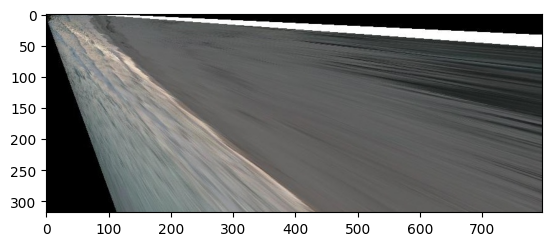

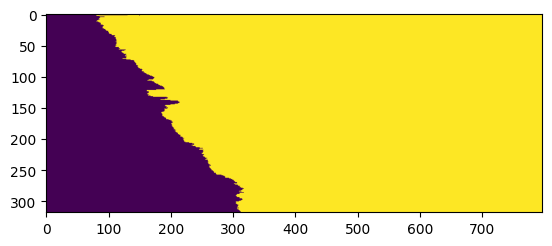

In [13]:
img_path = sorted(data['test']['images'])[2]
print(img_path)

pred = model.predict(img_path)

img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(img)
plt.show()

plt.imshow(pred)
plt.show()

# Save the results to an output folder

In [5]:
# Data with 4 classes, to be able to compute the shoreline distance

data_path = os.path.abspath(os.path.join(os.getcwd(), "../../../data/processed_bilstm_global"))

coast_data = CoastData(data_path)
split = coast_data.split_data()

data = DataLoaderManager.load_data(split)

CoastData: global - 1717 images
Coast: agrelo, Total size: 244
Coast: arenaldentem, Total size: 40
Coast: cadiz, Total size: 946
Coast: cies, Total size: 430
Coast: samarador, Total size: 57


In [6]:
# Create a folders system to save the results
# SCLabels_prediction_by_set_unet
#   - images
#       - train
#       - validation
#       - test
#   - masks
#       - train
#       - validation
#       - test
#   - predicted_mask
#       - train
#       - validation
#       - test

# Create the folders
subfolders = ["images", "masks", "predicted_mask"]
subset = ["train", "validation", "test"]

path = os.path.abspath(os.path.join(os.getcwd(), "../../../data/SCLabels_prediction_by_set_bilstm/"))

os.makedirs(path, exist_ok=True)
for subfolder in subfolders:
    for s in subset:
        os.makedirs(os.path.join(path, subfolder, s), exist_ok=True)

In [8]:
for split in data:
    print(f"Split: {split}")
    for img_path, mask_path in zip(data[split]["images"], data[split]["masks"]):
        pred = model.predict(img_path)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        
        # Save the images
        img = cv2.imread(img_path)
        img_name = os.path.basename(img_path)
        mask_name = os.path.basename(mask_path)

        cv2.imwrite(os.path.join(path, "images", split, img_name), img)
        cv2.imwrite(os.path.join(path, "masks", split, mask_name), mask)
        cv2.imwrite(os.path.join(path, "predicted_mask", split, mask_name), pred.cpu().numpy())

Split: train
Split: validation
Split: test
